See https://discourse.julialang.org/t/whats-wrong-with-my-chi-squared-goodness-of-fits-tests/64334

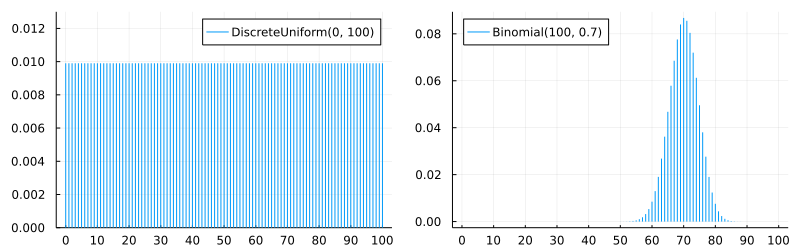

In [1]:
using Distributions, StatsPlots
P = plot(DiscreteUniform(0, 100); label="DiscreteUniform(0, 100)", xtick=0:10:100, ylim=(0, 0.013))
Q = plot(Binomial(100, 0.7); label="Binomial(100, 0.7)", legend=:topleft, xtick=0:10:100)
plot(P, Q; size=(800, 250))

In [2]:
using Distributions, Random, StatsPlots

# The test definitions.....
function computeDensity(data, supp)
    counts =  [count(i -> i==s,data) for s in supp]
    if length(data) > sum(counts)
        error("There are some data not in the support !")
    end
    return counts
end

"""
Modified version of `goodnessOfFitDiscrete` function in
https://discourse.julialang.org/t/whats-wrong-with-my-chi-squared-goodness-of-fits-tests/64334

* The old argument `support` is deleted.
* The new local variable `supp` is defined to be `support(f₀)`
"""
function goodnessOfFitDiscrete(data, f₀; compressedData=true, α=0.05, d=0)
    supp       = support(f₀)
    if !compressedData
        data   = computeDensity(data, supp)
    end
    K          = length(supp)
    N          = sum(data)
    p̂          = data ./ N
    df         = K - d - 1
    p0         = pdf.(f₀,supp)
    T          = N * sum((p̂[k] - p0[k])^2/p0[k] for k in 1:K)
    χDist      = Chisq(df)
    rejectedH₀ = T > quantile(χDist, 1-α)
    p_value    = 1 - cdf(χDist, T)
    return (testValue=T, threashold=quantile(χDist,1-α), rejectedH₀=rejectedH₀, p_value=p_value)
end

function repeat_tests(f₀; datasize = 10000, repetitions = 10000, α = 0.05, d = 0)
    testValue = zeros(repetitions)
    rejectedH₀ = falses(repetitions)
    data = rand(f₀, datasize)
    for rep in 1:repetitions
        rand!(f₀, data)
        out = goodnessOfFitDiscrete(data, f₀; compressedData=false, α, d)
        testValue[rep] = out.testValue
        rejectedH₀[rep] = out.rejectedH₀
    end
    α_real = sum(rejectedH₀)/repetitions
    (; α_real, testValue, rejectedH₀)
end

function plot_testValue_dist(f₀; datasize = 10000, repetitions = 10000, α = 0.05, d=0)
    α_real, testValue, rejectedH₀ = repeat_tests(f₀; datasize, repetitions, α, d)

    title = "$f₀   (real α = $α_real / nominal α = $α)"
    plot(; title, titlefontsize=10)

    xlim=(0, 2length(support(f₀)))
    a, b = xlim
    histogram!(testValue[a .≤ testValue .≤ b]; norm=true, alpha=0.3, label="testValue", xlim)

    df = length(support(f₀)) - d - 1
    plot!(Chisq(df), a, b; label="Chisq(df = $df)", ls=:dash, lw=2)
end

plot_testValue_dist (generic function with 1 method)

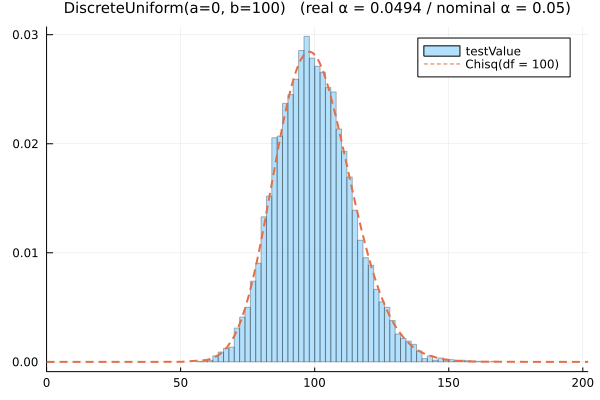

In [3]:
plot_testValue_dist(DiscreteUniform(0, 100))

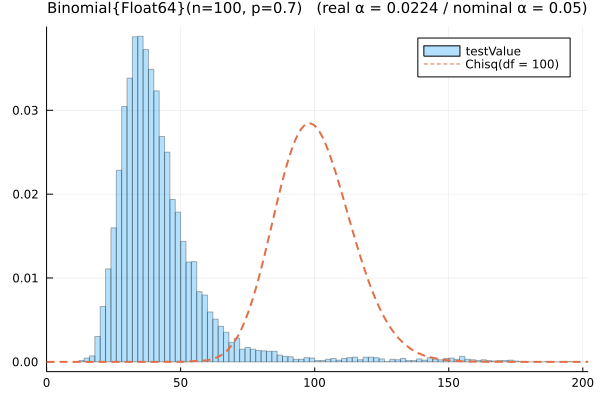

In [4]:
plot_testValue_dist(Binomial(100, 0.7))

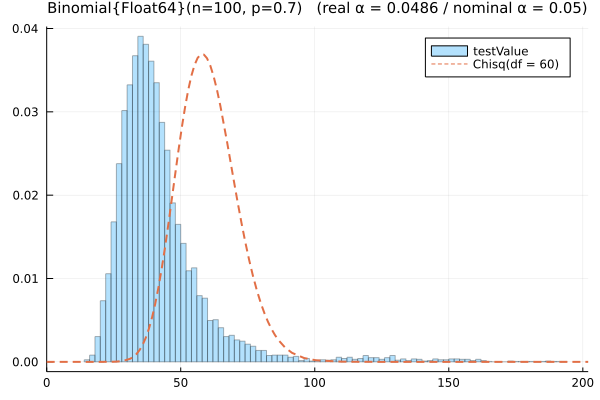

In [5]:
plot_testValue_dist(Binomial(100, 0.7); d = 40)